# 몬테카를로 학습 블랙잭

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from BlackJack import Player, Dealer

In [3]:
class StateActionInfo(object):
    def __init__(self):
        self.stateActionPairs = []
        self.stateActionMap = set()

    def addPair(self, pair):
        if pair in self.stateActionMap:
            return
        self.stateActionPairs.append(pair)
        self.stateActionMap.add(pair)

In [4]:
def evaluateAndImprovePolicy(qMap, policy, returns, stateActionPairs, reward):
    for pair in stateActionPairs:
        returns[pair] += 1
        qMap[pair] += (reward - qMap[pair]) / returns[pair]
        state = pair[0]
        shouldHit = True if qMap[(state, True)] > qMap[(state, False)] else False
        policy[state] = shouldHit

In [5]:
def newCard():
    card = np.random.randint(1, 14)
    return 10 if card > 9 else card

In [6]:
def playEpisode(qMap, policy, returns):
    playerSum = np.random.randint(11,22)
    dealerOpenCard = np.random.randint(1,11)
    usableAce = bool(np.random.randint(0,2))

    player = Player(playerSum, usableAce, dealerOpenCard)
    dealer = Dealer([dealerOpenCard])

    stateActionInfo = StateActionInfo()
    hitAction = bool(np.random.randint(0,2))
    stateActionInfo.addPair((player.getState(), hitAction))

    if hitAction:
        player.receiveCard(newCard())
        while not player.bust() and player.shouldHit(policy):
            stateActionInfo.addPair((player.getState(), True))
            player.receiveCard(newCard())

    if player.bust():
        evaluateAndImprovePolicy(qMap, policy, returns, stateActionInfo.stateActionPairs, -1)
        return

    stateActionInfo.addPair((player.getState(), False))
    dealer.receiveCard(newCard())

    while not dealer.bust() and dealer.shouldHit():
        dealer.cards.append(newCard())

    if dealer.bust() or dealer.getValue() < player.getValue():
        evaluateAndImprovePolicy(qMap, policy, returns, stateActionInfo.stateActionPairs, 1)
    elif dealer.getValue() > player.getValue():
        evaluateAndImprovePolicy(qMap, policy, returns, stateActionInfo.stateActionPairs, -1)
    else:
        evaluateAndImprovePolicy(qMap, policy, returns, stateActionInfo.stateActionPairs, 0)

In [7]:
qMap, policy, returns = {}, {}, {}

for playerSum in range(11,22):
    for usableAce in range(2):
        for dealerCard in range(1, 11):
            playerState = (playerSum, bool(usableAce), dealerCard)
            qMap[(playerState, True)] = 0
            qMap[(playerState, False)] = 0
            returns[(playerState, True)] = 0
            returns[(playerState, False)] = 0

            if playerSum == 20 or playerSum == 21:
                policy[playerState] = False
            else:
                policy[playerState] = True

In [8]:
for _ in range(1000000):
    playEpisode(qMap, policy, returns)

In [9]:
x11,y11,x12,y12,x21,y21,x22,y22=[],[],[],[],[],[],[],[]

for playerState in policy:
    if playerState[1]:
        if policy[playerState]:
            x11.append(playerState[2] - 1)
            y11.append(playerState[0] - 11)
        else:
            x12.append(playerState[2] - 1)
            y12.append(playerState[0] - 11)
    else:
        if policy[playerState]:
            x21.append(playerState[2] - 1)
            y21.append(playerState[0] - 11)
        else:
            x22.append(playerState[2] - 1)
            y22.append(playerState[0] - 11)

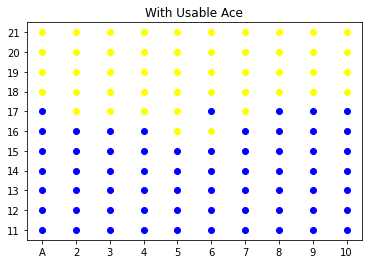

In [10]:
# Ace를 가지고 있는 경우
plt.title('With Usable Ace')
plt.scatter(x11, y11, color='blue')
plt.scatter(x12, y12, color='yellow')
plt.xticks(range(10), ['A','2','3','4','5','6','7','8','9','10'])
plt.yticks(range(11), ['11','12','13','14','15','16','17','18','19','20','21'])
plt.show()

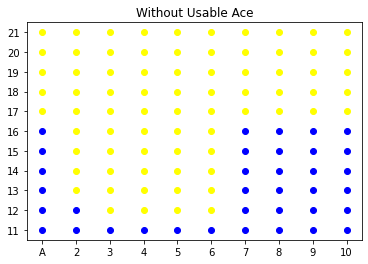

In [11]:
# Ace를 가지고 있지 않은 경우
plt.title('Without Usable Ace')
plt.scatter(x21, y21, color='blue')
plt.scatter(x22, y22, color='yellow')
plt.xticks(range(10), ['A','2','3','4','5','6','7','8','9','10'])
plt.yticks(range(11), ['11','12','13','14','15','16','17','18','19','20','21'])
plt.show()